In [5]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import pandas as pd
from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import importlib as il
from tqdm import tqdm

import fast_time_interp

import pyIGRF as pyigrf
import apexpy
from apexpy import Apex

from scipy.signal import butter, sosfiltfilt, sosfilt_zi, sosfilt, lfilter, filtfilt, savgol_filter, wiener, order_filter
from numpy.polynomial import Chebyshev


In [6]:
# sat1 to sat3 are quiet time passes and sat4 to sar6 are storm time passes

path = 'time_interpolated_data/'

file_path =['time_interpolated_data/1_quiet_0020_sat_pass.nc', 'time_interpolated_data/2_quiet_0202_sat_pass.nc', 'time_interpolated_data/3_quiet_0344_sat_pass.nc', 'time_interpolated_data/4_storm_1539_sat_pass.nc', 'time_interpolated_data/5_storm_1719_sat_pass.nc', 'time_interpolated_data/6_storm_1901_sat_pass.nc']


sat1 = xr.open_dataset(file_path[0])
sat2 = xr.open_dataset(file_path[1])
sat3 = xr.open_dataset(file_path[2])
sat4 = xr.open_dataset(file_path[3])
sat5 = xr.open_dataset(file_path[4])
sat6 = xr.open_dataset(file_path[5])

sat = [sat1, sat2, sat3, sat4, sat5, sat6]

sat1


<xarray.Dataset>
Dimensions:        (sat_step: 1822, sami_time: 596)
Coordinates:
    glat           (sat_step) float64 ...
    glon           (sat_step) float64 ...
    alt            (sat_step) float64 ...
    sat_time       (sat_step) datetime64[ns] ...
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    interpd_edens  (sat_step) float64 ...
    edens          (sami_time, sat_step) float64 ...

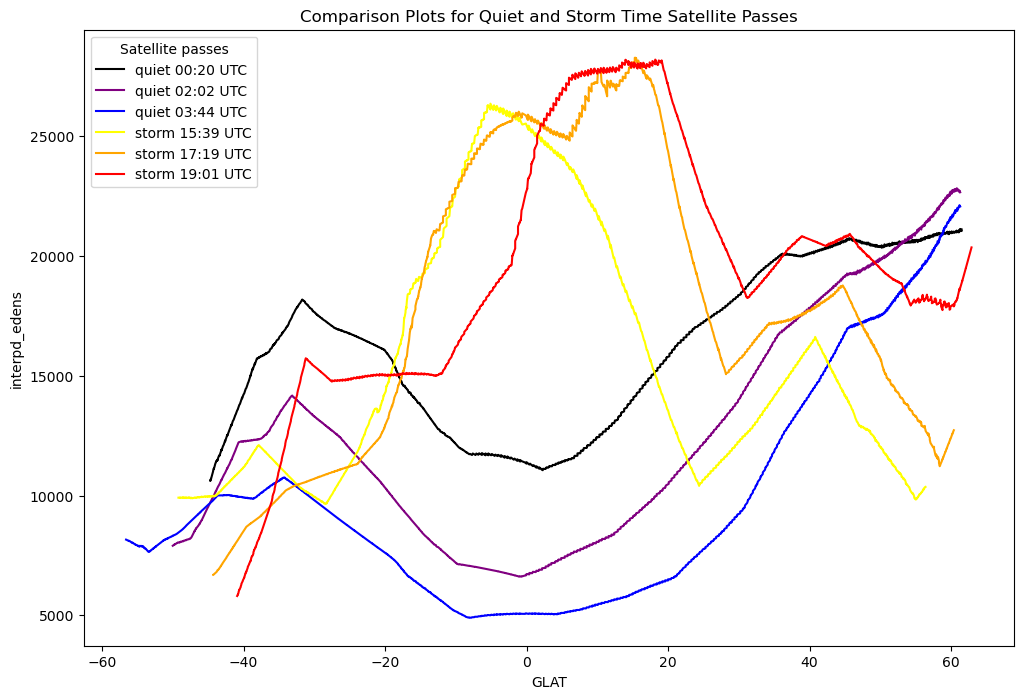

In [9]:
# Plotting for comparison of different satellite passes

fast_time_interp = il.reload(fast_time_interp)

fast_time_interp.plot_edens(sat, 'interpd_edens')


In [10]:
print(sat1.alt.values)

[857.3 857.2 857.2 ... 860.  860.1 860.2]


### Using fitting on sat1 only for time being

In [12]:
import filter_self


filter_self = il.reload(filter_self)

y = sat1['interpd_edens'].values
x = sat1['glat'].values

name, yf = filter_self.best_filters(x, y)

['Savgol Filter', 'Polynomial Fitting', 'Chebyshev Fitting', 'Rolling mean']


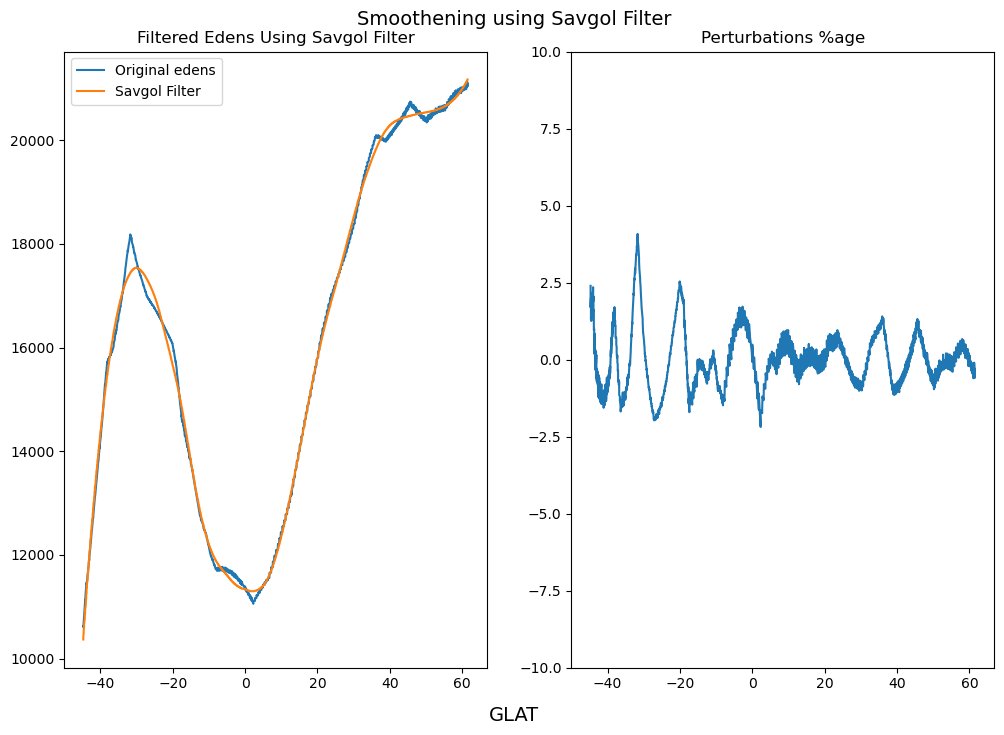

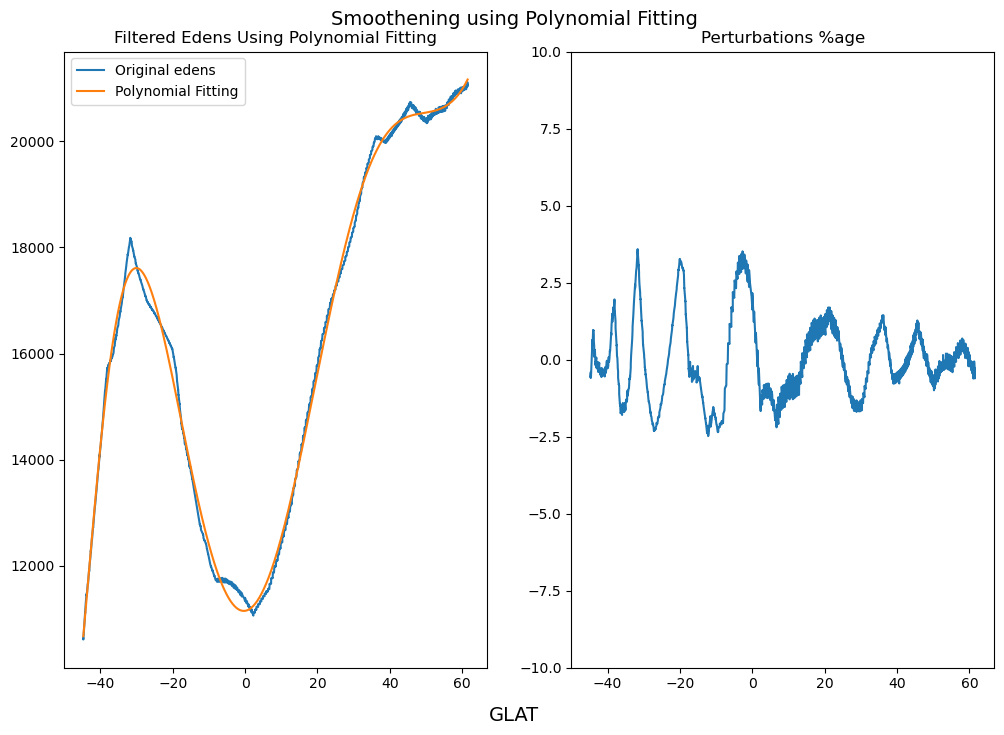

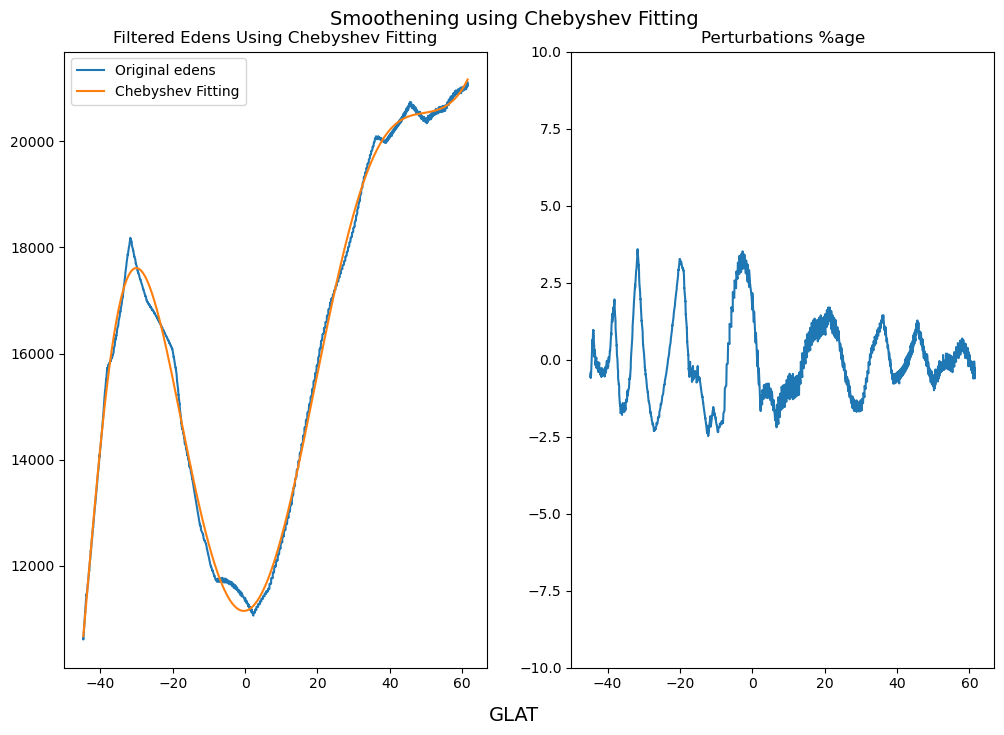

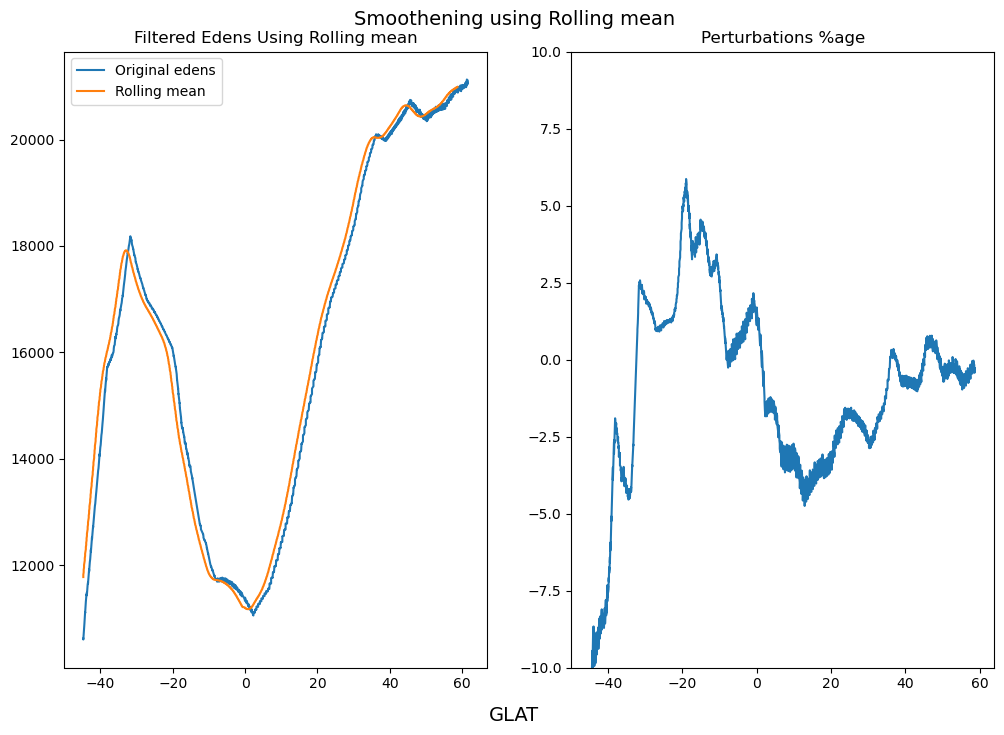

In [13]:
print(name)
#print(yf)

perturb =  np.zeros(x.shape)

for f, n in zip(yf, name):

    perturb = 100*(y-f)/y
    
    fig, axs = plt.subplots(1,2, figsize=(12,8))
    axs[0].plot(x, y, label='Original edens')
    axs[0].plot(x, f, label=n)
    axs[0].set_title('Filtered Edens Using ' + n)
    axs[0].legend()
    
    axs[1].plot(x, perturb)
    axs[1].set_title('Perturbations %age')
    axs[1].set_ylim(-10,10)
    fig.text(0.5, 0.05, 'GLAT', ha='center', va='center', fontsize=14)
    fig.text(0.5, 0.92, 'Smoothening using ' + n, ha='center', va='center', fontsize=14)



In [16]:

'''


# filter_self = il.reload(filter_self)


# from scipy.signal import order_filter, wiener, savgol_filter, hilbert

y = sat1['interp_edens'].values
x = sat1['glat'].values
print(len(y))

num = int(input('Enter the index for filter: '))
name = ['Order_filter', 'Wiener', 'Savgol_filter', 'Hilbert', 'Polyfit', 'Chebyshev', 'Rolling mean']
window = int(input('Degree or Window Size: '))

yf = np.zeros(len(y))

if num == 0:
    # window = 50
    yf = order_filter(y, np.ones(101), rank=window)

elif num == 1:
    # window = 180
    yf = wiener(y,window)

elif num == 2:
    # window = 500
    yf = savgol_filter(y, window, 4) # best results at 4

elif num == 3:
    # window = 500
    
    yy = hilbert(y)
    envelope = np.abs(yy)
    ins_phase = np.unwrap(np.angle(yy))

    ins_phase2 = wiener(ins_phase,window)
    reconstruct = envelope*np.exp(1j*ins_phase)

    yf = np.real(reconstruct)
    
    plt.figure(figsize = (12,8))
    plt.plot(ins_phase)
    plt.plot(ins_phase2)
    plt.show()

elif num == 4:
    
    # window = 10
    yf = filter_self.polyfitting(window, x, y)

elif num == 5:

    # window = 10
    c = Chebyshev.fit(x, y, window)
    yf = c(x)
    print(yf)
    
elif num == 6:

    # window = 50
    yf1 = np.convolve(y, np.ones(window)/window, mode='valid')
    yf = np.zeros(len(y))
    for i in range(len(y)):
        if i-1 < window:
            yf[i] = np.NaN
        
        else:
            yf[i] = yf1[i-window]
    
    print(len(yf))
    #yf = sat1.rolling(on='interp_edens', time=window, center=True).mean().dropna()


perturb = np.zeros(sat1['glat'].shape)

for i in range(len(perturb)):
    perturb[i] = 100*(y[i]-yf[i])/y[i]

fig, axs = plt.subplots(1,2, figsize=(12,8))
axs[0].plot(sat1['glat'], y, label='orig')
axs[0].plot(sat1['glat'], yf, label='filt')
axs[0].set_title('Filtered Edens with Degree/Window ' + str(window))
axs[0].legend()

axs[1].plot(sat1['glat'], perturb)
axs[1].set_title('Perturbations %age')
axs[1].set_ylim(-10,10)
fig.text(0.5, 0.05, 'GLAT', ha='center', va='center', fontsize=14)
fig.text(0.5, 0.92, 'Smoothening using ' + name[num], ha='center', va='center', fontsize=14)

''';

100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.26s/it]


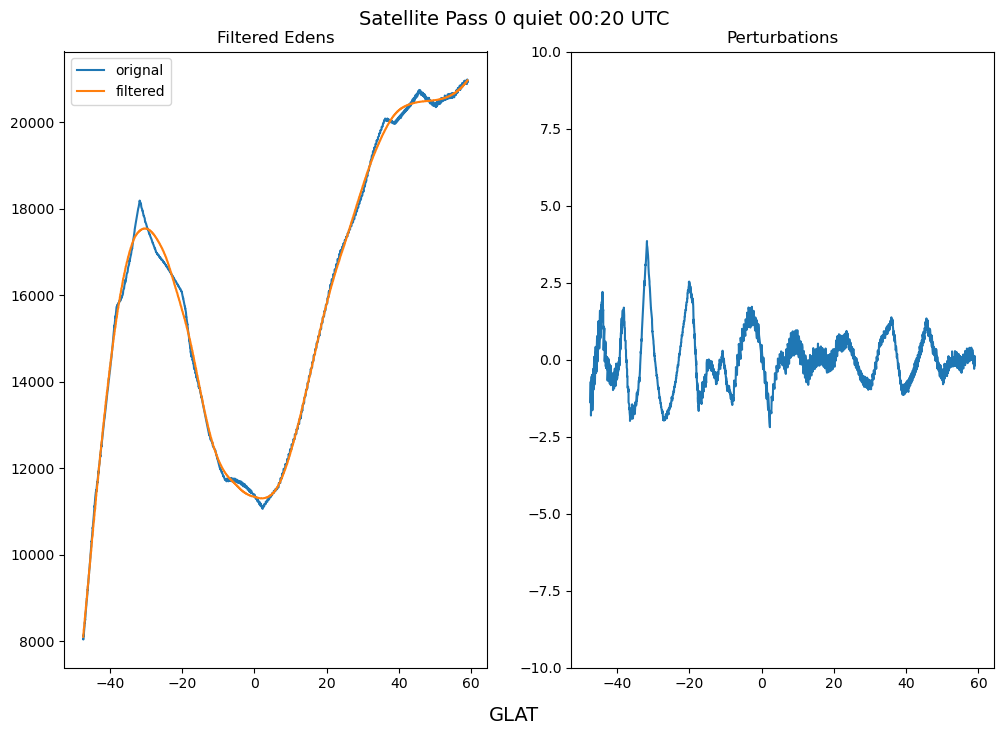

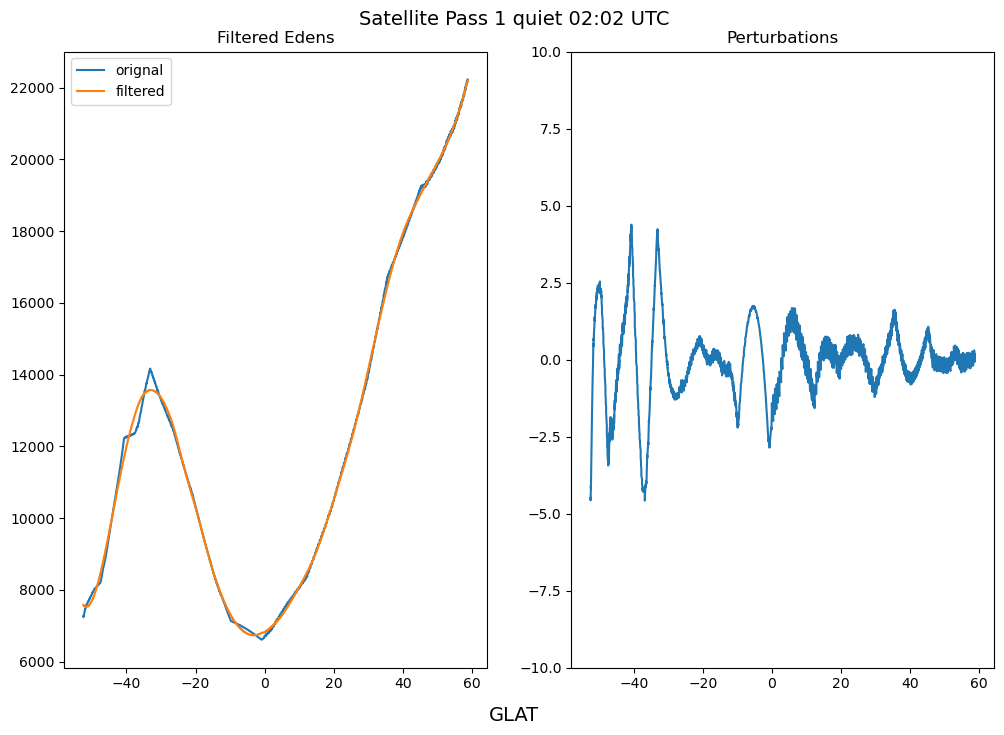

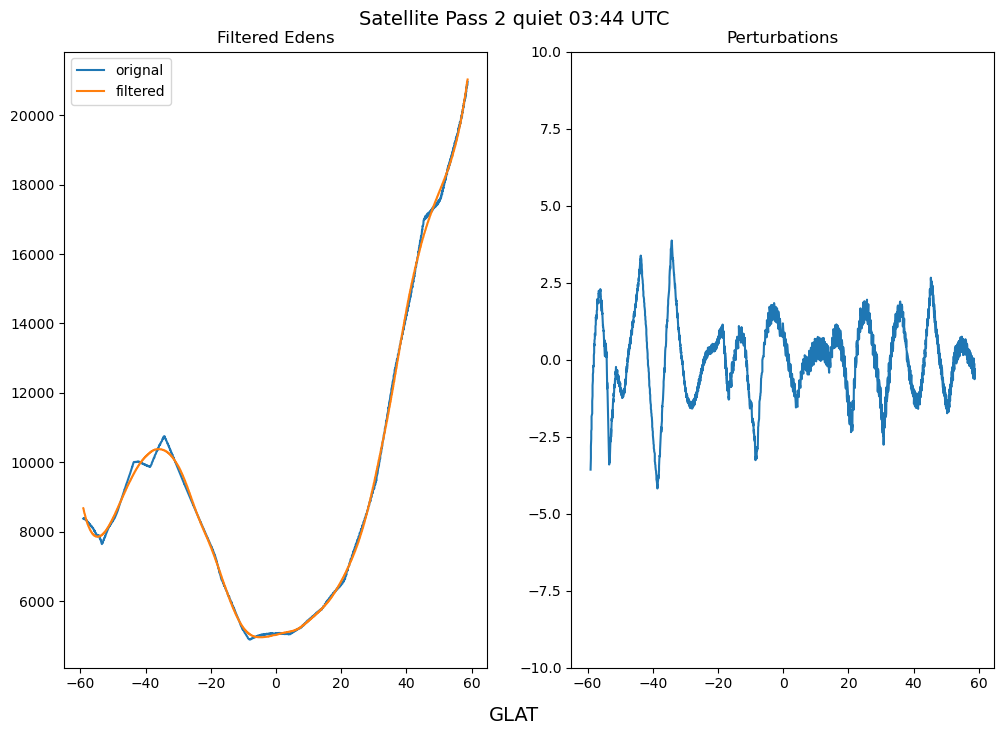

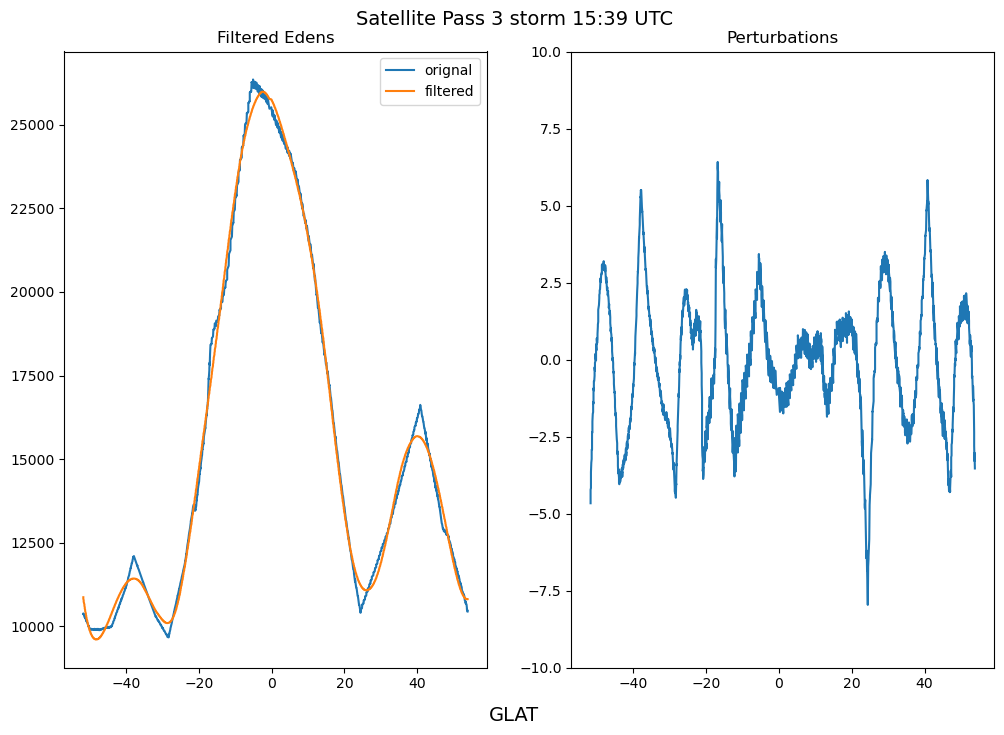

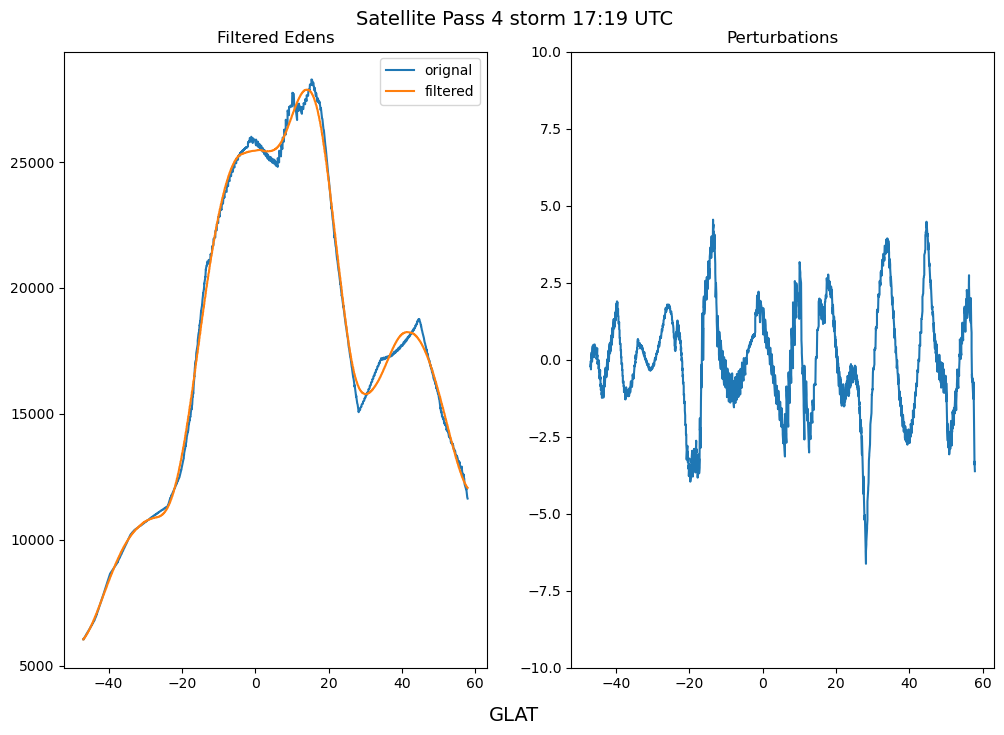

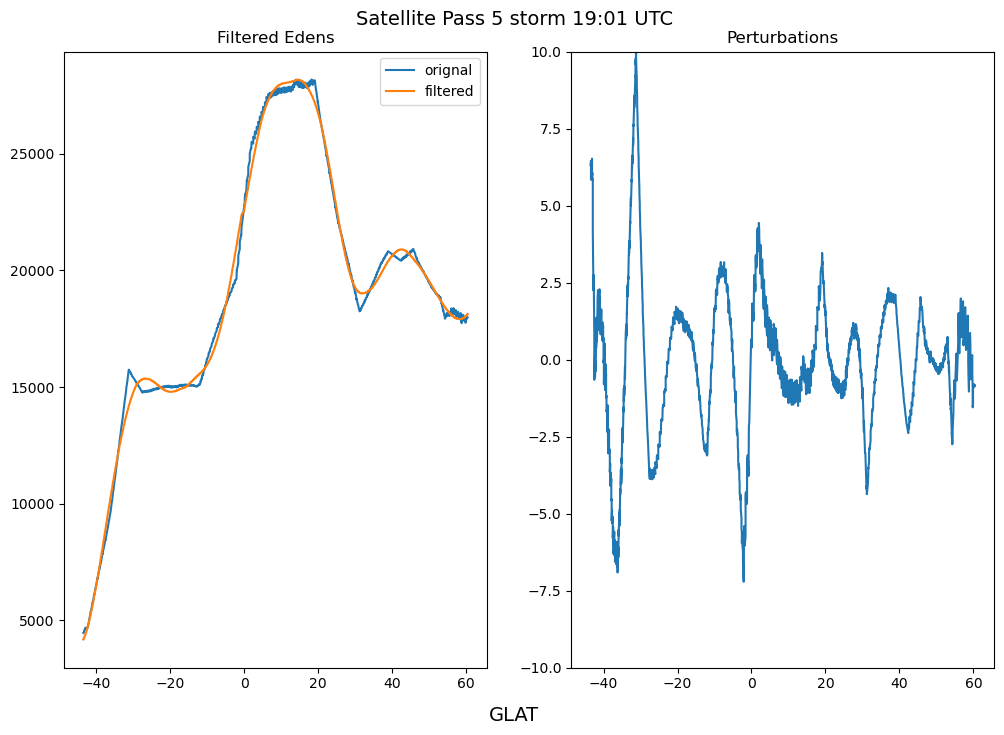

In [7]:
n = 0
label = ['quiet 00:20 UTC', 'quiet 02:02 UTC', 'quiet 03:44 UTC', 'storm 15:39 UTC', 'storm 17:19 UTC', 'storm 19:01 UTC']

for s in tqdm(sat):
    y = s['interp_edens']
    x = s['glat']
    
    filter = savgol_filter(y, 500, 4)
    perturbations = np.zeros(len(y))
    
    for i in range(len(y)):
        perturbations[i] = 100*(y[i] - filter[i])/y[i]
    
    #s['filt_edens'] = ('sat_step', filter)
    #s['perturb'] = ('sat_step', perturbations)

    fig, axs = plt.subplots(1,2, figasize=(12,8))
    axs[0].plot(s['glat'], y, label='orignal')
    axs[0].plot(s['glat'], filter, label='filtered')
    axs[0].set_title('Filtered Edens')
    axs[0].legend()
    axs[1].plot(s['glat'], perturbations)
    axs[1].set_title('Perturbations %age')
    axs[1].set_ylim(-10,10)
    plt.title('Perturbations')
    fig.text(0.5, 0.05, 'GLAT', ha='center', va='center', fontsize=14)
    fig.text(0.5, 0.92, 'Satellite Pass ' + str(n) + ' ' + label[n], ha='center', va='center', fontsize=14)

    n += 1



# Trying Smoothening or Filtering on Complete Satellite Data

100%|████████████████████████████████████| 86101/86101 [04:03<00:00, 353.26it/s]


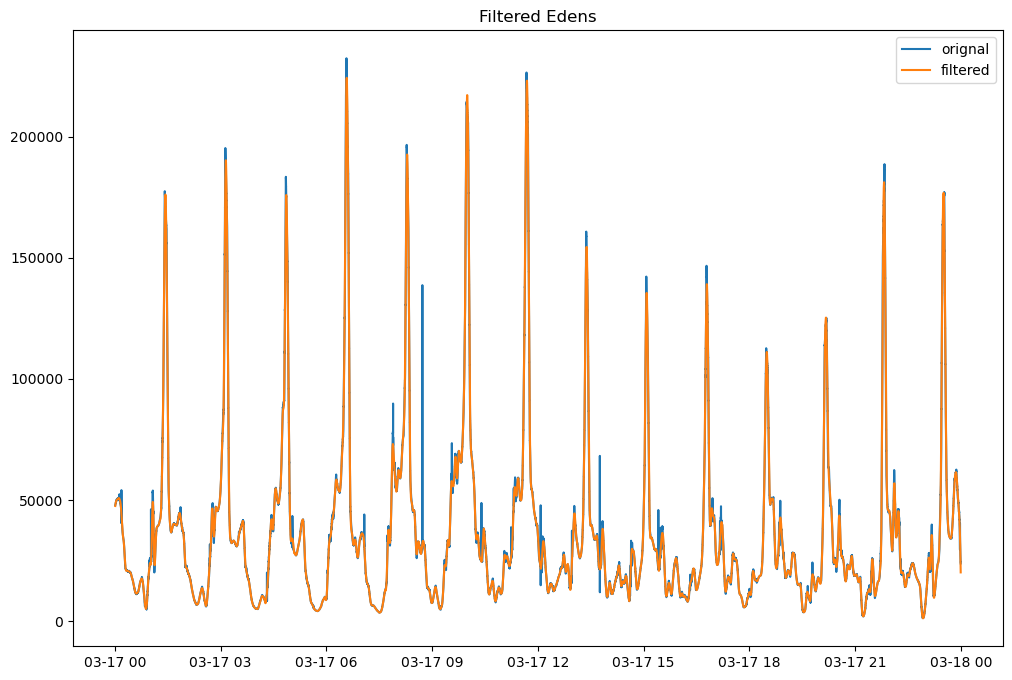

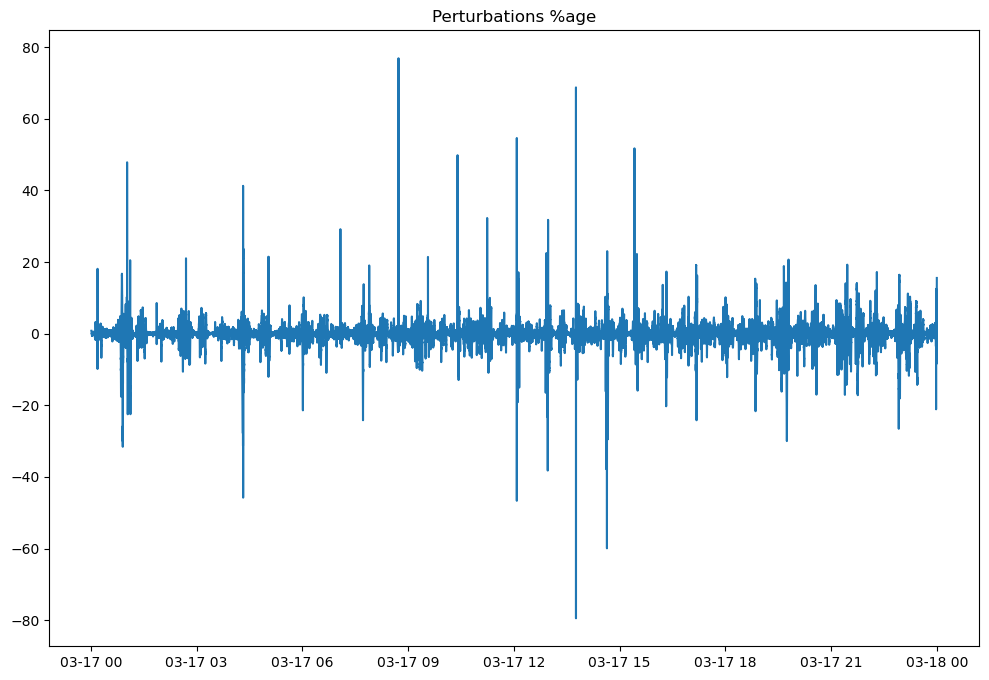

In [51]:

sat_c = xr.open_dataset('/time_interpolated_data/parallel_data/sat_data.nc')

y = sat_c['interp_edens']
x = sat_c['glat']

filter = savgol_filter(y, 500, 4)
perturbations = np.zeros(len(y))

for i in tqdm(range(len(y))):
    perturbations[i] = 100*(y[i] - filter[i])/y[i]

plt.figure(figsize=(12,8))
plt.plot(sat_c['sat_time'], y, label='orignal')
plt.plot(sat_c['sat_time'], filter, label='filtered')
plt.title('Filtered Edens')
plt.legend()
plt.ylim(0,25000)
plt.show()

plt.figure(figsize=(12,8))
plt.plot(sat_c['sat_time'], perturbations)
plt.title('Perturbations %age')
plt.show()

# Center the filters